## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#I'm setting the seed to assure you get the same answers on quizzes as I set up
random.seed(42)

C:\Users\Simin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Firsr read in the `ab_data.csv` data and store it in `df`. 
df= pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Find the number of rows in the dataset
df.shape

(294478, 5)

In [5]:
# Check to see if there is any duplicate in the dataset
sum(df.duplicated())

0

In [6]:
# The number of unique users in the dataset
df['user_id'].nunique()

290584

In [7]:
# The proportion of users converted
df['converted'].mean()

0.11965919355605512

In [8]:
# The number of times the new_page and treatment don't line up
df.query(('group == "treatment" and landing_page != "new_page" or group != "treatment" and landing_page == "new_page"'))['group'].count()

3893

In [9]:
#Check if the rows have missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, I cannot be sure if this row truly received the new or old page. I drop these rows and store the results in df2.


In [10]:
df2= df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [11]:
# Double Check all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
# Number of unique user_id's in df2
df2['user_id'].nunique()

290584

In [13]:
#repeated user_id in df2
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
#the row information for the repeated user_id
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# Drop the duplicated user 
df2.drop([1899,], axis='rows', inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#Check the results
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# The probability of an individual converting regardless of the page they receive?
df2['converted'].mean()

0.11959708724499628

In [18]:
# Given that an individual was in the `control` group, what is the probability they converted?
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [19]:
# Given that an individual was in the treatment group, what is the probability they converted?
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [20]:
#The probability that an individual received the new page
(df2.group == "treatment").mean()

0.50006194422266881

**Results:** Based on the results of what I've done so far, there is no evidence that one page leads to more conversions. Half of the users are in the "treatment" and the other half are in the "control" group, and the rate of conversion is 0.12 for both.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I want to make the decision just based on all the data provided. I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are as followed:

**$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

** Hypothesis **

$$H_0:p_{new}-p_{old}<=0$$
$$H_1:p_{new}-p_{old}>0$$

`2.` I'll Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I'll assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I'll use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I'll perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

I'll use the cells below to provide the necessary parts of this simulation.

a. The **convert rate** for  $p_{new}$  under the null

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. The **convert rate** for  $p_{old}$  under the null

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. $n_{new}$

In [23]:
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()
n_new

145310

d. $n_{old}$

In [24]:
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(n=1, p=p_new, size=n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n=1, p=p_old, size=n_old)

g. Find $p_{new}$ - $p_{old}$

In [27]:
new_page_converted.mean()-old_page_converted.mean()

0.00051401567146014404

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using the same process in parts a. through g. above and store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    new_bootsamp = np.random.binomial(n=1, p=p_new, size=n_new)
    old_bootsamp = np.random.binomial(n=1, p=p_old, size=n_old)
    p_diffs.append(new_bootsamp.mean() - old_bootsamp.mean())
    

i. Plot a histogram of the **p_diffs**.

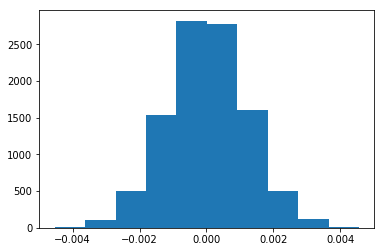

In [29]:
plt.hist(p_diffs);

j. Find the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [30]:
obs_diff = df2.query('group == "treatment"')['converted'].mean()-df2.query('group == "control"')['converted'].mean()

In [31]:
(p_diffs > obs_diff).mean()

0.91139999999999999

k. What I computed  in part **j.** was the **p-value**. p_value is the proportion of values in the null distribution which are greater than my observed difference.
Since the p-value is a large number, I fail to reject null hypothesis. It means there is no significant difference between the new and old pages.

l. I could also use a built-in to achieve similar results by calculating the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()
convert_old, convert_new, n_old ,n_new  

(17489, 17264, 145274, 145310)

m. Now I use `stats.proportions_ztest` to compute my test statistic and p-value. 

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new, n_old])
p_value, z_score

(0.18988337448195103, -1.3109241984234394)

I calculated p_value under two_tail test, because I left the 'alternative' with default value of "two_sided" . p_value is differnt than the one I calculated in **j.** section. The p_value calculated in section **j.** is for a one_tail test(p_new - p_old <= 0)

In [34]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new, n_old], alternative='larger')
p_value, z_score

(0.90505831275902449, -1.3109241984234394)

I set the 'alternative' to "larger", and get the same p_value calculated in **j.** section. with this p_value I fail to reject null hypothesis.  

<a id='regression'></a>
### Part III - A regression approach

In this final part,  will see that the result I acheived in the previous A/B test can also be acheived by performing regression.<br>

a. Since each row is either a conversion or no conversion, I should perform Logistic Regression in this case.

b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However I first need to create a column for the **intercept**, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import logistic regression model. 

In [37]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the results.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        17:38:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with ab_page is 0.19.

In linear regression, I discuss if there is a significant linear relationship between the dependent variable/column X(in my case ab_page) and independent variable/column Y(converted). <br>
The null hypothesis assosiated with regression is that there is no significant relationship between ab_page and converted columns which means conversion rate is not dependent on the page visited by user(old/new page). and the alternative hypothesis is that there is a relationship between ab_page and converted columns. These cause a two_tail hypothesis.<br>

** Hypothesis: **

$$H_0:p_{new}-p_{old} = 0$$
$$H_1:p_{new}-p_{old} != 0$$

The p_value I calculated in the regression model is under a two_tail test. In Part II, section m. under a two_tail test I found the same value for p_value, however under a one_tail hypothesis the p_value was 0.91.


** f. Is it a good idea to consider other factors to add into my regression model? what are the pros and cons? ** <br>
Considering other factors to add into my regression model could help us to predict the result better or finding more associated variables, on the other hand it could cause complexity in interpreting the results or collinearity which is correlation between predictor variables that can lead to coefficients being flipped from the direction I expect from simple linear regression.

g. Now along with testing if the conversion rate changes for different pages, I also add an effect based on which country a user lives. I will read in the **countries.csv** dataset and merge together my datasets on the approporiate rows.  
I want to see if country had an impact on conversion? 

In [39]:
#reading countries.csv file
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
#checking for null values in countries.df dataset
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [41]:
#checing if I have the same row number in df2 as countries_df
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


In [42]:
#Joining the two datasets and saving the results in df3
df3 = df2.set_index('user_id').join(countries_df.set_index('user_id'))
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [43]:
#finding the existing country in my dataset to help us create necessary dummy variables
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [44]:
#creating dummy variables for exising countries
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('CA', axis=1)
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [45]:
log_mod =sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        17:38:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

According to the results, because all the p-values are greater than 0.05, there isn't any statistically significant relationship between the variables and the response variable(converted)

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0